# Advanced Lane Line Findings

Note: All the process to detect lane lines in test video is executed in `process_image` function in `Defining image processing method` section. 

## Camera Calibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

def collect_callibration_points():
    objpoints = []
    imgpoints = []
   
    images = glob.glob('./camera_cal/calibration*.jpg')
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)
    
    for fname in images:
        img = mpimg.imread(fname)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        
    return imgpoints, objpoints

def compare_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=50)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    
imgpoints, objpoints = collect_callibration_points()
img = mpimg.imread('./camera_cal/calibration3.jpg')
undistorted, mtx, dist_coefficients = cal_undistort(img, objpoints, imgpoints)
#compare_images(img, undistorted, "Original Image", "Undistorted Image")

image_path = './test_images/straight_lines1_1.jpg'
image = mpimg.imread(image_path)
image, mtx, dist_coefficients = cal_undistort(image, objpoints, imgpoints)

## Gradient Thresholds

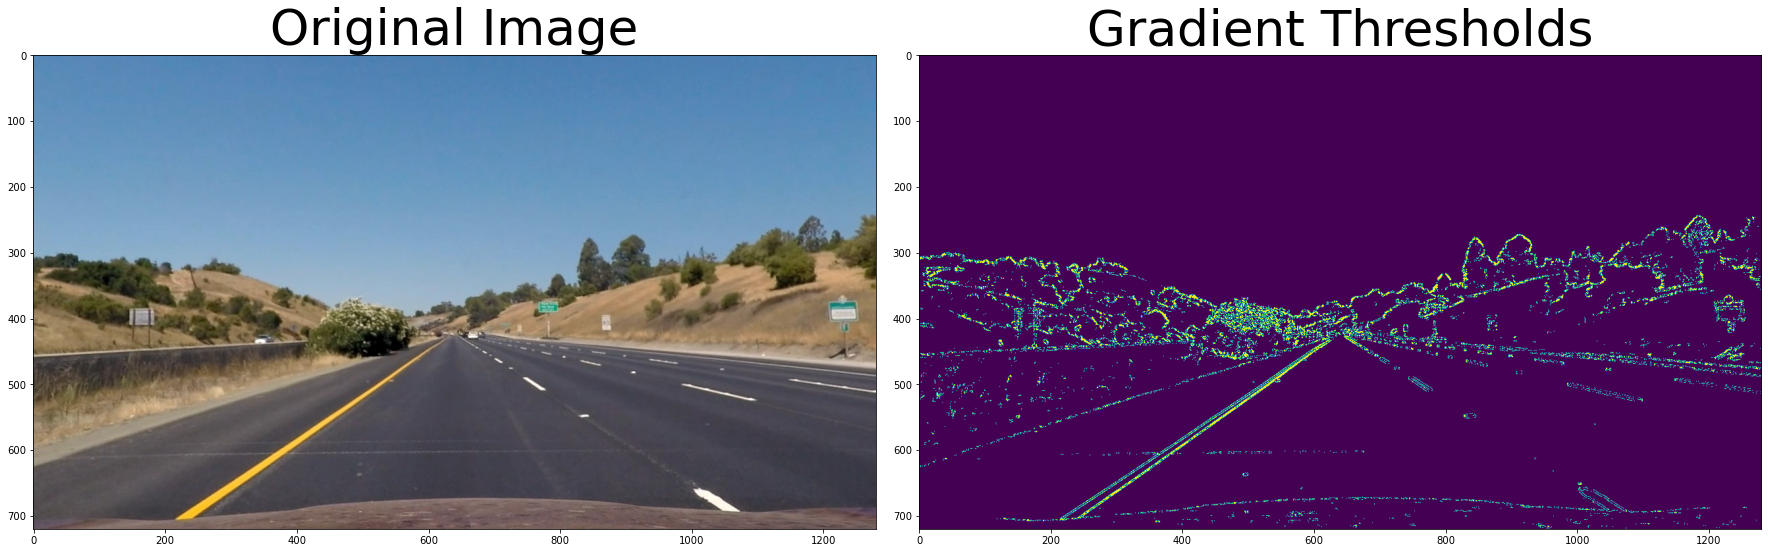

In [3]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    isX = True if orient == 'x' else False
    sobel = cv2.Sobel(gray, cv2.CV_64F, isX, not isX)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) 
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
   
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) 
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1

    return dir_binary

def apply_thresholds(image, ksize=3):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

combined = apply_thresholds(image)
compare_images(image, combined, "Original Image", "Gradient Thresholds")

## Color Threshold

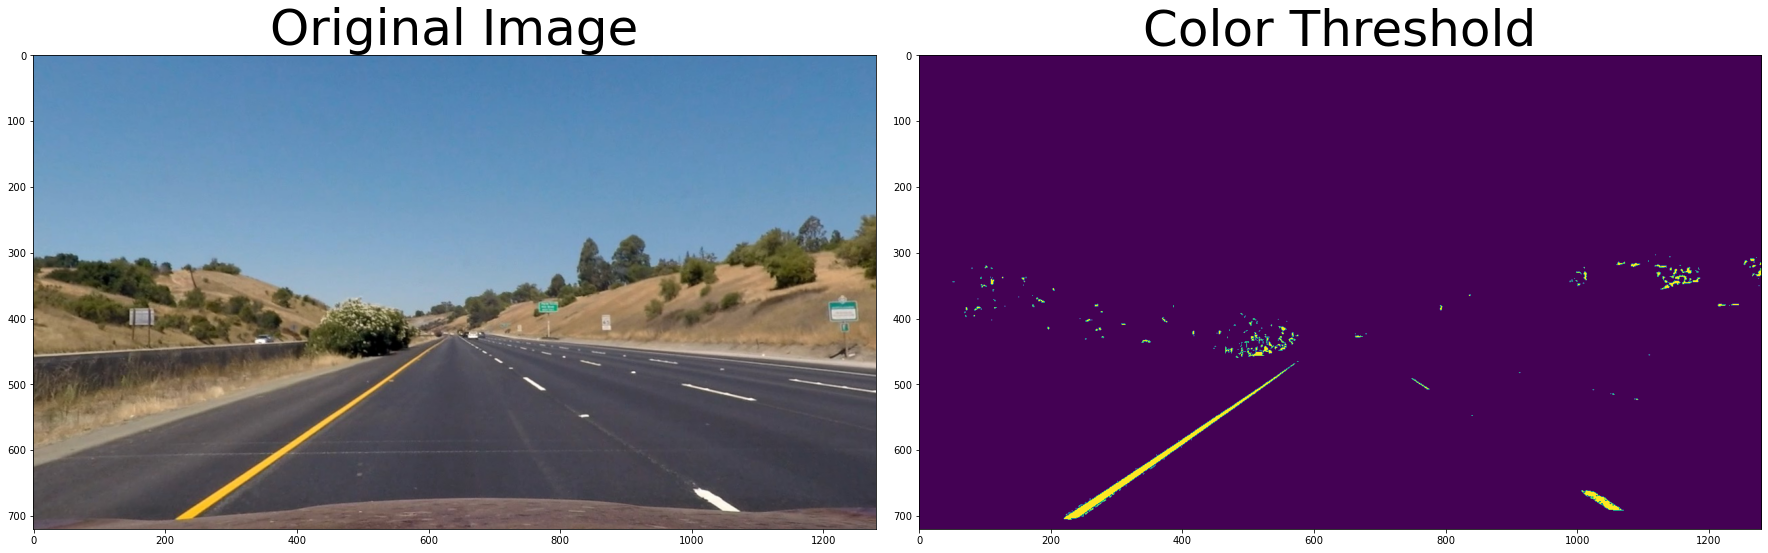

In [4]:
def apply_color_threshold(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    return s_binary
    
    
s_binary = apply_color_threshold(image)
compare_images(image, s_binary, "Original Image", "Color Threshold")

## Combine Color and Gradient

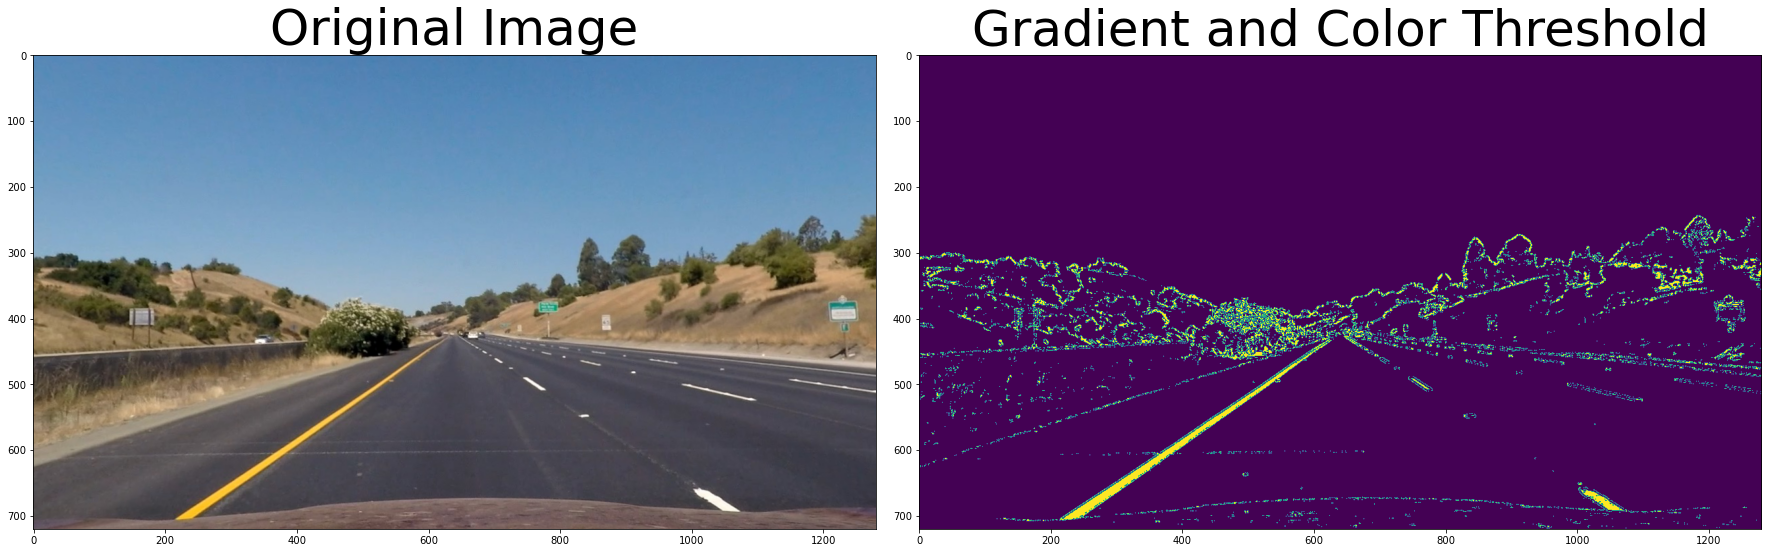

In [5]:
def combine_threshold(s_binary, combined):
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1

    return combined_binary


combined_binary = combine_threshold(s_binary, combined)
compare_images(image, combined_binary, "Original Image", "Gradient and Color Threshold")

## Perspective Transform

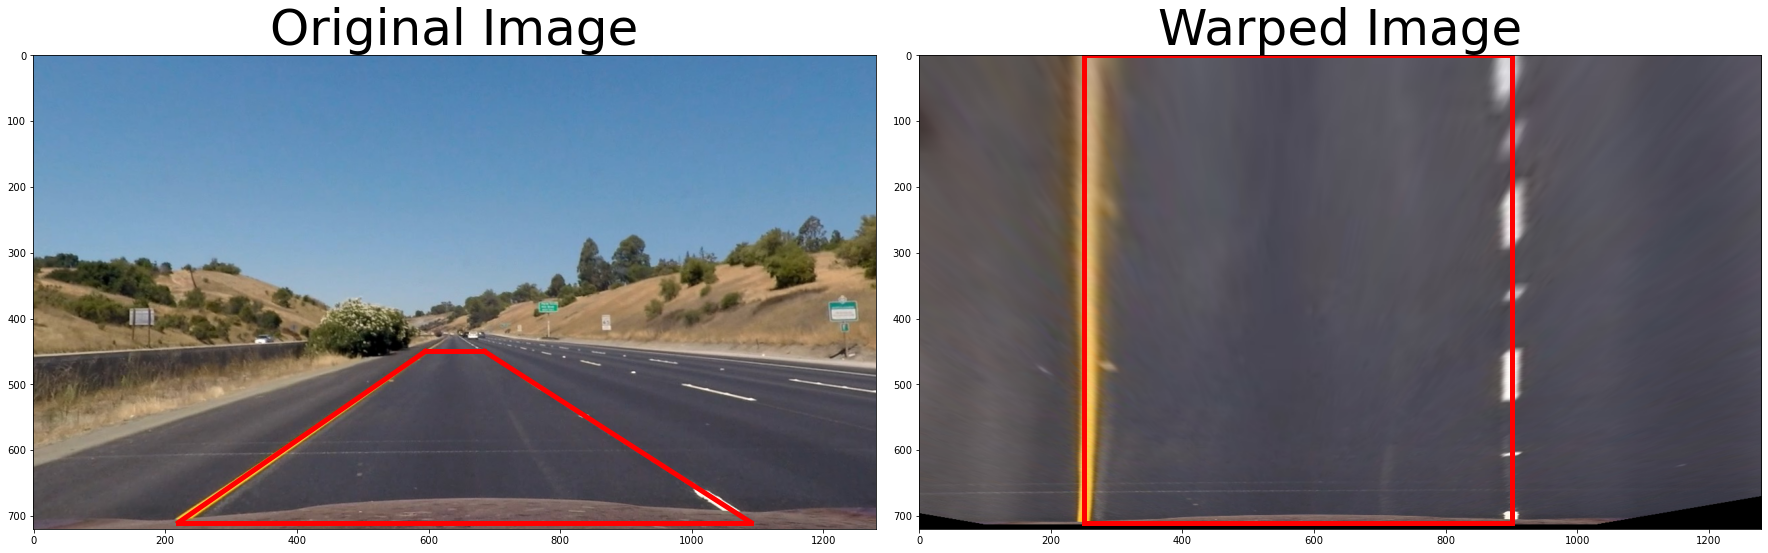

In [6]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
        [[685, 450], 
          [1090, 710], 
          [220, 710], 
          [595, 450]])
    
    dst = np.float32(
        [[900, 0], 
          [900, 710], 
          [250, 710], 
          [250, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    binary_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
   
    return binary_warped, Minv

def compare_plotted_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.plot([685, 1090], [450, 710], color='r', linewidth="5")
    ax1.plot([1090, 220], [710, 710], color='r', linewidth="5")
    ax1.plot([220, 595], [710, 450], color='r', linewidth="5")
    ax1.plot([595, 685], [450, 450], color='r', linewidth="5")
    ax1.set_title(image1_exp, fontsize=50)
    ax2.imshow(image2)
    ax2.plot([900, 900], [0, 710], color='r', linewidth="5")
    ax2.plot([900, 250], [710, 710], color='r', linewidth="5")
    ax2.plot([250, 250], [710, 0], color='r', linewidth="5")
    ax2.plot([250, 900], [0, 0], color='r', linewidth="5")
    ax2.set_title(image2_exp, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    
warped, Minv = warp(image)
compare_plotted_images(image, warped, "Original Image", "Warped Image")

# Finding the Lines

## Histogram

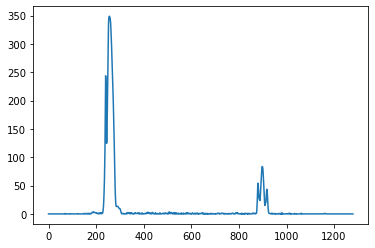

In [7]:
def get_histogram(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    return histogram
    
    
binary_warped, Minv = warp(combined_binary)
histogram = get_histogram(binary_warped)
plt.plot(histogram)

## Sliding Window

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


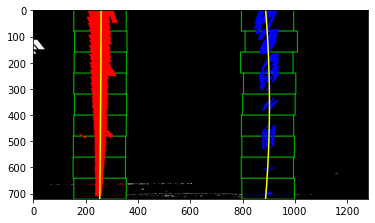

In [8]:
def slide_window(binary_warped, histogram):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return ploty, left_fit, right_fit

ploty, left_fit, right_fit = slide_window(binary_warped, histogram)

## Skipping Slinding Window

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


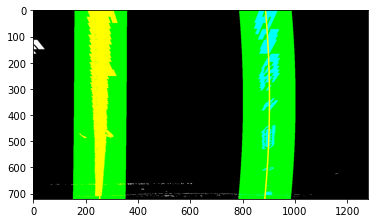

In [9]:
def skip_sliding_window(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
  
    
    ################################ 
    ## Visualization
    ################################ 
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    ret = {}
    ret['leftx'] = leftx
    ret['rightx'] = rightx
    ret['left_fitx'] = left_fitx
    ret['right_fitx'] = right_fitx
    ret['ploty'] = ploty
    
    return ret

draw_info = skip_sliding_window(binary_warped, left_fit, right_fit)

## Measuring Curvature

In [10]:
def measure_curvature(ploty, lines_info):
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 

    leftx = lines_info['left_fitx']
    rightx = lines_info['right_fitx']

    leftx = leftx[::-1]  
    rightx = rightx[::-1]  

    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad
    
left_curverad, right_curverad = measure_curvature(ploty, draw_info)

21277.11250618704 m 1293.6347887196248 m


## Drawing

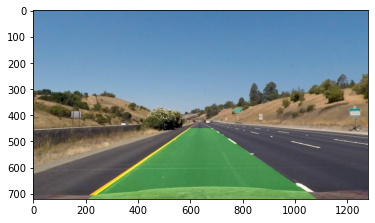

In [11]:
def draw_lane_lines(original_image, warped_image, Minv, draw_info):
    leftx = draw_info['leftx']
    rightx = draw_info['rightx']
    left_fitx = draw_info['left_fitx']
    right_fitx = draw_info['right_fitx']
    ploty = draw_info['ploty']
    
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0])) 
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    
    return result


result = draw_lane_lines(image, binary_warped, Minv, draw_info)
plt.imshow(result)

## Defining image processing method

In [12]:
global used_warped
global used_ret

def process_image(image):
    global used_warped
    global used_ret
    
    #Undistort image
    image, mtx, dist_coefficients = cal_undistort(image, objpoints, imgpoints)
    
    # Gradient thresholding
    gradient_combined = apply_thresholds(image)
   
    # Color thresholding
    s_binary = apply_color_threshold(image)
    
    # Combine Gradient and Color thresholding
    combined_binary = combine_threshold(s_binary, gradient_combined)
   
    # Transforming Perspective
    binary_warped, Minv = warp(combined_binary)
  
    # Getting Histogram
    histogram = get_histogram(binary_warped)
  
    # Sliding Window to detect lane lines
    ploty, left_fit, right_fit = slide_window(binary_warped, histogram)
    
    # Skipping Sliding Window
    ret = skip_sliding_window(binary_warped, left_fit, right_fit)
   
    # Measuring Curvature
    left_curverad, right_curverad = measure_curvature(ploty, ret)
    
     # Sanity check: whether the lines are roughly parallel and have similar curvature
    slope_left = ret['left_fitx'][0] - ret['left_fitx'][-1]
    slope_right = ret['right_fitx'][0] - ret['right_fitx'][-1]
    slope_diff = abs(slope_left - slope_right)
    slope_threshold = 150
    curve_diff = abs(left_curverad - right_curverad)
    curve_threshold = 10000
    
    if (slope_diff > slope_threshold or curve_diff > curve_threshold):
        binary_warped = used_warped
        ret = used_ret
   
    # Visualizing Lane Lines Info
    result = draw_lane_lines(image, binary_warped, Minv, ret)
    
    # Annotating curvature 
    fontType = cv2.FONT_HERSHEY_SIMPLEX
    curvature_text = 'The radius of curvature = ' + str(round(left_curverad, 3)) + 'm'
    cv2.putText(result, curvature_text, (30, 60), fontType, 1.5, (255, 255, 255), 3)
   
    # Annotating deviation
    deviation_pixels = image.shape[1]/2 - abs(ret['right_fitx'][-1] - ret['left_fitx'][-1])
    xm_per_pix = 3.7/700 
    deviation = deviation_pixels * xm_per_pix
    direction = "left" if deviation < 0 else "right"
    deviation_text = 'Vehicle is ' + str(round(abs(deviation), 3)) + 'm ' + direction + ' of center'
    cv2.putText(result, deviation_text, (30, 110), fontType, 1.5, (255, 255, 255), 3)
    
    used_warped = binary_warped
    used_ret = ret
    
    return result 

#result_image = process_image(image)
#plt.imshow(result_image)

## Applying to Video 

In [13]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg-win32-v3.2.4.exe' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-win32-v3.2.4.exe (34.1 MB)
Downloading: 8192/35749888 bytes (0.057344/35749888 bytes (0.2%155648/35749888 bytes (0.4278528/35749888 bytes (0.8376832/35749888 bytes (1.1491520/35749888 bytes (1.4606208/35749888 bytes (1.7745472/35749888 bytes (2.1884736/35749888 bytes (2.51081344/35749888 bytes (3.0%1318912/35749888 bytes (3.7%1466368/35749888 bytes (4.1%1597440/35749888 bytes (4.5%1703936/35749888 bytes (4.8%1818624/35749888 bytes (5.1%1949696/35749888 bytes (5.5%2056192/35749888 bytes (5.8%2392064/35749888 bytes (6.7%2506752/35749888 bytes (7.0%2621440/35749888 bytes (7.3%2744320/35749888 bytes (7.7%2859008/35749888 bytes (8.0%2973696/35749888 bytes (8.3%3088384/35749888 bytes (8.6%3194880/35749888 bytes (8.9%3309568/35749888 bytes (9.3%3563520/35749888 bytes (10.03645440/35749888 bytes (10.23776512/35749888 by

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


373.06845538003904 m 658.7152126622549 m


t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video result.mp4.
Moviepy - Writing video result.mp4



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                    | 2/1260 [00:01<17:27,  1.20it/s, now=None]

373.06845538003904 m 658.7152126622549 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                                   | 3/1260 [00:03<22:40,  1.08s/it, now=None]

387.00884595204593 m 546.24255952812 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                                   | 4/1260 [00:04<26:07,  1.25s/it, now=None]

388.19798520388525 m 618.068241349626 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                                   | 5/1260 [00:06<28:36,  1.37s/it, now=None]

377.5073558472105 m 514.3749758321807 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                                   | 6/1260 [00:08<30:15,  1.45s/it, now=None]

407.42806325492853 m 440.2990372401002 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                                   | 7/1260 [00:09<31:30,  1.51s/it, now=None]

399.90695262617936 m 387.00422587580505 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                                   | 8/1260 [00:11<32:15,  1.55s/it, now=None]

407.84507428399894 m 381.6099082694549 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                                   | 9/1260 [00:13<32:46,  1.57s/it, now=None]

435.5075127455734 m 355.9306597975343 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▌                                                                  | 10/1260 [00:14<33:14,  1.60s/it, now=None]

438.6773214656934 m 482.55000947955466 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▌                                                                  | 11/1260 [00:16<33:39,  1.62s/it, now=None]

417.8456874321319 m 570.6978499063429 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▋                                                                  | 12/1260 [00:18<33:57,  1.63s/it, now=None]

419.6259233208169 m 848.1753173544608 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▋                                                                  | 13/1260 [00:19<34:13,  1.65s/it, now=None]

447.72832746894403 m 717.3267660344296 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▋                                                                  | 14/1260 [00:21<34:07,  1.64s/it, now=None]

434.8721899166022 m 772.1471796451231 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▊                                                                  | 15/1260 [00:23<34:14,  1.65s/it, now=None]

446.6162429726159 m 530.8439065027833 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▊                                                                  | 16/1260 [00:24<34:12,  1.65s/it, now=None]

451.31197604013505 m 442.51425943089146 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▉                                                                  | 17/1260 [00:26<34:04,  1.65s/it, now=None]

424.24225683990346 m 367.99767859497837 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▉                                                                  | 18/1260 [00:28<34:17,  1.66s/it, now=None]

415.34995592580526 m 335.3895230498572 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   2%|█                                                                  | 19/1260 [00:29<34:20,  1.66s/it, now=None]

488.96372251347714 m 354.1625793702011 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   2%|█                                                                  | 20/1260 [00:31<34:39,  1.68s/it, now=None]

490.63086158121314 m 334.1392853846094 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   2%|█                                                                  | 21/1260 [00:33<34:53,  1.69s/it, now=None]

499.7394770178207 m 334.58714832932156 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   2%|█▏                                                                 | 22/1260 [00:34<34:47,  1.69s/it, now=None]

505.00449395087423 m 308.1103144394779 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   2%|█▏                                                                 | 23/1260 [00:36<34:44,  1.69s/it, now=None]

499.0177476507935 m 317.016415079795 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   2%|█▎                                                                 | 24/1260 [00:38<34:30,  1.68s/it, now=None]

518.9930761672747 m 371.9534699088938 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   2%|█▎                                                                 | 25/1260 [00:39<34:43,  1.69s/it, now=None]

463.74401362287426 m 471.98868774728896 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   2%|█▍                                                                 | 26/1260 [00:41<35:29,  1.73s/it, now=None]

429.6196960686244 m 702.1313647452712 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   2%|█▍                                                                 | 27/1260 [00:43<35:12,  1.71s/it, now=None]

443.5516128328336 m 854.2941747395715 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   2%|█▍                                                                 | 28/1260 [00:45<34:47,  1.69s/it, now=None]

424.8397907575431 m 653.8006760979505 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   2%|█▌                                                                 | 29/1260 [00:46<34:40,  1.69s/it, now=None]

437.9674145693965 m 609.6523360085085 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   2%|█▌                                                                 | 30/1260 [00:48<34:25,  1.68s/it, now=None]

431.0338436514324 m 475.9241321154085 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   2%|█▋                                                                 | 31/1260 [00:50<34:24,  1.68s/it, now=None]

374.5829566186386 m 495.4145696078749 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   3%|█▋                                                                 | 32/1260 [00:51<34:30,  1.69s/it, now=None]

356.9111374843752 m 296.90278224567396 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   3%|█▊                                                                 | 33/1260 [00:53<34:15,  1.68s/it, now=None]

327.0077366921299 m 284.2341702576293 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   3%|█▊                                                                 | 34/1260 [00:55<34:22,  1.68s/it, now=None]

323.3241693069167 m 265.92320276847965 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   3%|█▊                                                                 | 35/1260 [00:56<34:14,  1.68s/it, now=None]

330.03769270815343 m 336.21016632173144 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   3%|█▉                                                                 | 36/1260 [00:58<33:56,  1.66s/it, now=None]

317.94865852625423 m 399.44291237242464 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   3%|█▉                                                                 | 37/1260 [01:00<34:21,  1.69s/it, now=None]

292.7517849573412 m 411.35893043964523 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   3%|██                                                                 | 38/1260 [01:01<34:18,  1.68s/it, now=None]

287.9092162805167 m 381.8377748692334 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   3%|██                                                                 | 39/1260 [01:03<34:10,  1.68s/it, now=None]

290.28034182706944 m 281.9328014348604 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   3%|██▏                                                                | 40/1260 [01:05<33:52,  1.67s/it, now=None]

279.0249339288264 m 268.4081757225712 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   3%|██▏                                                                | 41/1260 [01:06<34:08,  1.68s/it, now=None]

285.388622554874 m 314.4426755739411 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   3%|██▏                                                                | 42/1260 [01:08<33:44,  1.66s/it, now=None]

299.39595176885797 m 268.4703630571863 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   3%|██▎                                                                | 43/1260 [01:10<33:37,  1.66s/it, now=None]

321.9390111161152 m 277.76611229906746 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   3%|██▎                                                                | 44/1260 [01:11<34:15,  1.69s/it, now=None]

335.9738508918107 m 276.176573908181 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   4%|██▍                                                                | 45/1260 [01:13<33:53,  1.67s/it, now=None]

357.89691709420845 m 273.6013539952224 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   4%|██▍                                                                | 46/1260 [01:15<33:30,  1.66s/it, now=None]

352.14165306342693 m 294.82801588970534 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   4%|██▍                                                                | 47/1260 [01:16<33:50,  1.67s/it, now=None]

386.2763090864246 m 294.41500513453553 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   4%|██▌                                                                | 48/1260 [01:18<33:34,  1.66s/it, now=None]

386.71543716549496 m 348.0353158906923 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   4%|██▌                                                                | 49/1260 [01:20<33:34,  1.66s/it, now=None]

397.97598815701775 m 423.5023522862247 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   4%|██▋                                                                | 50/1260 [01:21<33:45,  1.67s/it, now=None]

440.2017056874529 m 437.7286412329594 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   4%|██▋                                                                | 51/1260 [01:23<33:41,  1.67s/it, now=None]

438.5371802353815 m 378.6722229723643 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   4%|██▊                                                                | 52/1260 [01:25<33:32,  1.67s/it, now=None]

455.4543224034041 m 489.968289307723 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   4%|██▊                                                                | 53/1260 [01:26<33:48,  1.68s/it, now=None]

441.3649097789612 m 445.5541248685533 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   4%|██▊                                                                | 54/1260 [01:28<34:04,  1.69s/it, now=None]

456.5710183916909 m 412.7072912157581 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   4%|██▉                                                                | 55/1260 [01:30<33:54,  1.69s/it, now=None]

476.3796502915819 m 394.87529525727933 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   4%|██▉                                                                | 56/1260 [01:31<33:44,  1.68s/it, now=None]

459.9691382695179 m 346.6621433865131 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   5%|███                                                                | 57/1260 [01:33<33:54,  1.69s/it, now=None]

498.0710331450219 m 346.4710577152752 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   5%|███                                                                | 58/1260 [01:35<33:57,  1.69s/it, now=None]

479.7395141410071 m 356.0348328090785 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   5%|███▏                                                               | 59/1260 [01:37<33:45,  1.69s/it, now=None]

464.1194284951626 m 404.6712576372642 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   5%|███▏                                                               | 60/1260 [01:38<33:42,  1.69s/it, now=None]

402.5841592191039 m 574.8812461015177 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   5%|███▏                                                               | 61/1260 [01:40<33:46,  1.69s/it, now=None]

405.16171925207146 m 326.0861239084652 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   5%|███▎                                                               | 62/1260 [01:42<34:11,  1.71s/it, now=None]

443.2647930145074 m 344.38023737286755 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   5%|███▎                                                               | 63/1260 [01:43<34:01,  1.71s/it, now=None]

419.79000118402746 m 312.5577111128822 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   5%|███▍                                                               | 64/1260 [01:45<33:43,  1.69s/it, now=None]

418.4339816187495 m 313.93970932328875 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   5%|███▍                                                               | 65/1260 [01:47<33:51,  1.70s/it, now=None]

408.2128610137319 m 295.14040389814295 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   5%|███▌                                                               | 66/1260 [01:49<34:01,  1.71s/it, now=None]

421.6804188006656 m 304.6835380699494 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   5%|███▌                                                               | 67/1260 [01:50<33:38,  1.69s/it, now=None]

390.2743144933685 m 356.176553918627 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   5%|███▌                                                               | 68/1260 [01:52<33:27,  1.68s/it, now=None]

414.19046685792904 m 380.35055791973747 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   5%|███▋                                                               | 69/1260 [01:53<33:13,  1.67s/it, now=None]

438.68405740432263 m 430.3452475794808 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   6%|███▋                                                               | 70/1260 [01:55<33:32,  1.69s/it, now=None]

409.44770259641524 m 380.99462466333983 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   6%|███▊                                                               | 71/1260 [01:57<33:34,  1.69s/it, now=None]

466.53947988503074 m 398.1274547947875 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   6%|███▊                                                               | 72/1260 [01:59<33:22,  1.69s/it, now=None]

458.6876640844653 m 455.5964915300678 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   6%|███▉                                                               | 73/1260 [02:00<33:20,  1.69s/it, now=None]

445.6513460291619 m 505.93289538304845 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   6%|███▉                                                               | 74/1260 [02:02<33:17,  1.68s/it, now=None]

460.80776789826245 m 390.98657389703163 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   6%|███▉                                                               | 75/1260 [02:04<33:03,  1.67s/it, now=None]

475.70357583013146 m 358.54557397585694 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   6%|████                                                               | 76/1260 [02:05<33:05,  1.68s/it, now=None]

512.4504549035217 m 325.909574746529 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   6%|████                                                               | 77/1260 [02:07<32:42,  1.66s/it, now=None]

485.3270971681812 m 354.95036885814267 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   6%|████▏                                                              | 78/1260 [02:09<33:12,  1.69s/it, now=None]

528.3824024631876 m 375.34817989301143 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   6%|████▏                                                              | 79/1260 [02:10<33:45,  1.71s/it, now=None]

582.4505882701376 m 433.1615767938371 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   6%|████▎                                                              | 80/1260 [02:12<33:26,  1.70s/it, now=None]

571.2778207181435 m 400.85228536604046 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   6%|████▎                                                              | 81/1260 [02:14<33:14,  1.69s/it, now=None]

555.3215648692809 m 370.9173998723498 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   7%|████▎                                                              | 82/1260 [02:15<33:08,  1.69s/it, now=None]

527.9360623239994 m 339.98090788624194 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   7%|████▍                                                              | 83/1260 [02:17<32:58,  1.68s/it, now=None]

536.8103053839216 m 340.5590340593897 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   7%|████▍                                                              | 84/1260 [02:19<33:10,  1.69s/it, now=None]

516.8918607313032 m 311.9420353783754 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   7%|████▌                                                              | 85/1260 [02:21<33:34,  1.71s/it, now=None]

528.1101470463391 m 333.7020554966402 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   7%|████▌                                                              | 86/1260 [02:22<33:33,  1.72s/it, now=None]

495.5128616750394 m 321.3775367630686 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   7%|████▋                                                              | 87/1260 [02:24<33:15,  1.70s/it, now=None]

426.79451848563826 m 432.16542895208215 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   7%|████▋                                                              | 88/1260 [02:26<33:06,  1.70s/it, now=None]

396.63343129928325 m 466.4837976523334 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   7%|████▋                                                              | 89/1260 [02:27<33:07,  1.70s/it, now=None]

368.02719321646293 m 441.3447526418264 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   7%|████▊                                                              | 90/1260 [02:29<33:00,  1.69s/it, now=None]

369.5106069160572 m 420.04971443487955 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   7%|████▊                                                              | 91/1260 [02:31<32:55,  1.69s/it, now=None]

334.1879602902627 m 306.89657120654505 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   7%|████▉                                                              | 92/1260 [02:32<33:09,  1.70s/it, now=None]

354.2165426379576 m 363.00159197267993 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   7%|████▉                                                              | 93/1260 [02:34<32:54,  1.69s/it, now=None]

370.2083108602489 m 350.5733560126526 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   7%|████▉                                                              | 94/1260 [02:36<32:55,  1.69s/it, now=None]

391.1384983373284 m 355.6462451664618 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   8%|█████                                                              | 95/1260 [02:37<32:44,  1.69s/it, now=None]

372.9458797567119 m 400.49300503643207 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   8%|█████                                                              | 96/1260 [02:39<33:04,  1.71s/it, now=None]

392.1028250724547 m 382.3451371833153 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   8%|█████▏                                                             | 97/1260 [02:41<33:03,  1.71s/it, now=None]

348.647042350744 m 317.75227185193404 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   8%|█████▏                                                             | 98/1260 [02:43<32:52,  1.70s/it, now=None]

345.44377146529496 m 433.63535162407106 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   8%|█████▎                                                             | 99/1260 [02:44<33:14,  1.72s/it, now=None]

358.73924886508354 m 383.10168106535997 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   8%|█████▏                                                            | 100/1260 [02:46<34:00,  1.76s/it, now=None]

342.3130170268606 m 367.30757598508427 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   8%|█████▎                                                            | 101/1260 [02:48<33:35,  1.74s/it, now=None]

344.39286818210485 m 438.62364616146243 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   8%|█████▎                                                            | 102/1260 [02:50<33:10,  1.72s/it, now=None]

344.49691986940513 m 365.42106361452056 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   8%|█████▍                                                            | 103/1260 [02:51<33:18,  1.73s/it, now=None]

345.09848217169457 m 413.7105398043635 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   8%|█████▍                                                            | 104/1260 [02:53<33:53,  1.76s/it, now=None]

340.99583409675915 m 290.4832949107585 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   8%|█████▌                                                            | 105/1260 [02:55<33:25,  1.74s/it, now=None]

343.5919385232402 m 291.5664865047464 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   8%|█████▌                                                            | 106/1260 [02:57<33:34,  1.75s/it, now=None]

361.31170326704273 m 324.8254580341276 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   8%|█████▌                                                            | 107/1260 [02:58<33:28,  1.74s/it, now=None]

369.16016070890157 m 298.0054109616939 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   9%|█████▋                                                            | 108/1260 [03:00<32:55,  1.71s/it, now=None]

363.18717355152137 m 286.48505699577606 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   9%|█████▋                                                            | 109/1260 [03:02<32:53,  1.71s/it, now=None]

345.19237562919807 m 271.0462114036089 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   9%|█████▊                                                            | 110/1260 [03:03<32:58,  1.72s/it, now=None]

370.440839200093 m 262.03939459818594 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   9%|█████▊                                                            | 111/1260 [03:05<33:17,  1.74s/it, now=None]

348.4506645890714 m 340.5249066629294 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   9%|█████▊                                                            | 112/1260 [03:07<32:57,  1.72s/it, now=None]

329.2360836209116 m 487.8782974603523 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   9%|█████▉                                                            | 113/1260 [03:09<32:30,  1.70s/it, now=None]

363.7732854200352 m 432.32740469134365 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   9%|█████▉                                                            | 114/1260 [03:10<32:34,  1.71s/it, now=None]

331.38353976328915 m 340.43941027297626 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   9%|██████                                                            | 115/1260 [03:12<32:25,  1.70s/it, now=None]

323.104307662678 m 360.99130963718324 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   9%|██████                                                            | 116/1260 [03:14<32:35,  1.71s/it, now=None]

307.3921697169067 m 300.74335390465126 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   9%|██████▏                                                           | 117/1260 [03:15<32:24,  1.70s/it, now=None]

307.6412893451281 m 281.7803480471791 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   9%|██████▏                                                           | 118/1260 [03:17<32:38,  1.71s/it, now=None]

326.27113164555595 m 289.95351411947314 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   9%|██████▏                                                           | 119/1260 [03:19<32:38,  1.72s/it, now=None]

327.2485378352077 m 269.7272959136611 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  10%|██████▎                                                           | 120/1260 [03:21<32:19,  1.70s/it, now=None]

334.1724604791826 m 295.79785554507407 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  10%|██████▎                                                           | 121/1260 [03:22<32:34,  1.72s/it, now=None]

329.8864457109924 m 335.8808254197312 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  10%|██████▍                                                           | 122/1260 [03:24<32:21,  1.71s/it, now=None]

330.4581173510717 m 370.12761148542194 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  10%|██████▍                                                           | 123/1260 [03:26<32:11,  1.70s/it, now=None]

338.9332708436216 m 421.1516230101694 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  10%|██████▍                                                           | 124/1260 [03:27<32:33,  1.72s/it, now=None]

316.2785067987443 m 371.26054462007784 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  10%|██████▌                                                           | 125/1260 [03:29<32:35,  1.72s/it, now=None]

314.963670990425 m 289.77976478781585 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  10%|██████▌                                                           | 126/1260 [03:31<32:15,  1.71s/it, now=None]

313.2724446239474 m 285.19989409493536 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  10%|██████▋                                                           | 127/1260 [03:33<32:05,  1.70s/it, now=None]

339.4915737596742 m 321.6007534258599 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  10%|██████▋                                                           | 128/1260 [03:34<32:03,  1.70s/it, now=None]

330.0564162990522 m 299.07788192019785 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  10%|██████▊                                                           | 129/1260 [03:36<31:57,  1.70s/it, now=None]

338.6061648017416 m 275.2964984125515 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  10%|██████▊                                                           | 130/1260 [03:38<31:28,  1.67s/it, now=None]

338.02345661605966 m 322.1847859638722 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  10%|██████▊                                                           | 131/1260 [03:39<31:46,  1.69s/it, now=None]

327.77042007410574 m 338.74605594651655 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  10%|██████▉                                                           | 132/1260 [03:41<31:44,  1.69s/it, now=None]

376.6068550109763 m 368.34798034845477 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  11%|██████▉                                                           | 133/1260 [03:43<31:29,  1.68s/it, now=None]

399.00566611386273 m 369.45932325249817 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  11%|███████                                                           | 134/1260 [03:44<31:41,  1.69s/it, now=None]

358.4939517462872 m 398.25455849359207 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  11%|███████                                                           | 135/1260 [03:46<31:32,  1.68s/it, now=None]

358.20501121409046 m 426.52935055308836 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  11%|███████                                                           | 136/1260 [03:48<31:42,  1.69s/it, now=None]

388.0063459579139 m 480.4197974259063 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  11%|███████▏                                                          | 137/1260 [03:49<32:05,  1.71s/it, now=None]

383.12207560370194 m 459.20251285801925 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  11%|███████▏                                                          | 138/1260 [03:51<32:03,  1.71s/it, now=None]

381.5723534685895 m 501.81270819499696 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  11%|███████▎                                                          | 139/1260 [03:53<31:57,  1.71s/it, now=None]

411.4667088210601 m 546.7825695623766 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  11%|███████▎                                                          | 140/1260 [03:54<31:30,  1.69s/it, now=None]

446.8086161938449 m 450.79898653958304 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  11%|███████▍                                                          | 141/1260 [03:56<31:37,  1.70s/it, now=None]

461.2833605558791 m 574.5872280488604 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  11%|███████▍                                                          | 142/1260 [03:58<31:26,  1.69s/it, now=None]

510.90901723678803 m 430.1596276466752 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  11%|███████▍                                                          | 143/1260 [04:00<31:28,  1.69s/it, now=None]

528.8817711016321 m 417.01376990802385 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  11%|███████▌                                                          | 144/1260 [04:01<31:29,  1.69s/it, now=None]

470.58528378747764 m 348.3741123135692 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  12%|███████▌                                                          | 145/1260 [04:03<31:25,  1.69s/it, now=None]

453.52382156712054 m 368.69702801579234 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  12%|███████▋                                                          | 146/1260 [04:05<31:21,  1.69s/it, now=None]

455.5280505003587 m 362.3080198728183 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  12%|███████▋                                                          | 147/1260 [04:06<31:39,  1.71s/it, now=None]

421.1842104997306 m 509.1853955978486 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  12%|███████▊                                                          | 148/1260 [04:08<31:30,  1.70s/it, now=None]

414.59040827567344 m 563.8439631888589 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  12%|███████▊                                                          | 149/1260 [04:10<31:06,  1.68s/it, now=None]

390.8904771289597 m 368.1941549465926 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  12%|███████▊                                                          | 150/1260 [04:11<31:28,  1.70s/it, now=None]

402.79478705954006 m 369.47779237846356 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  12%|███████▉                                                          | 151/1260 [04:13<31:30,  1.70s/it, now=None]

394.1057627039907 m 374.54885042014064 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  12%|███████▉                                                          | 152/1260 [04:15<31:22,  1.70s/it, now=None]

408.80470592935046 m 525.5888849636486 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  12%|████████                                                          | 153/1260 [04:16<31:04,  1.68s/it, now=None]

419.8344049469187 m 376.23500835583434 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  12%|████████                                                          | 154/1260 [04:18<31:12,  1.69s/it, now=None]

405.4977257967055 m 329.3808735811212 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  12%|████████                                                          | 155/1260 [04:20<31:08,  1.69s/it, now=None]

396.8613637897388 m 375.15529122188633 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  12%|████████▏                                                         | 156/1260 [04:22<30:53,  1.68s/it, now=None]

421.9816142339955 m 327.92627404535847 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  12%|████████▏                                                         | 157/1260 [04:26<48:42,  2.65s/it, now=None]

391.017775881144 m 340.046457744065 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  13%|████████▎                                                         | 158/1260 [04:28<43:35,  2.37s/it, now=None]

398.88144790557106 m 369.31464346007834 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  13%|████████▎                                                         | 159/1260 [04:30<39:57,  2.18s/it, now=None]

368.95381621716734 m 463.8167511527936 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  13%|████████▍                                                         | 160/1260 [04:32<37:01,  2.02s/it, now=None]

392.68591885524893 m 394.64496600696145 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  13%|████████▍                                                         | 161/1260 [04:33<35:24,  1.93s/it, now=None]

371.12654038184655 m 361.35951493850683 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  13%|████████▍                                                         | 162/1260 [04:35<34:06,  1.86s/it, now=None]

388.30372573040967 m 481.7527862795929 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  13%|████████▌                                                         | 163/1260 [04:37<33:15,  1.82s/it, now=None]

401.05330729758055 m 399.48072014487957 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  13%|████████▌                                                         | 164/1260 [04:39<33:13,  1.82s/it, now=None]

405.6570779319713 m 397.24348296006065 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  13%|████████▋                                                         | 165/1260 [04:40<32:39,  1.79s/it, now=None]

416.1149466102841 m 341.1933960187033 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  13%|████████▋                                                         | 166/1260 [04:42<32:23,  1.78s/it, now=None]

376.93238489860187 m 243.5398744693535 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  13%|████████▋                                                         | 167/1260 [04:44<31:56,  1.75s/it, now=None]

404.0069190652999 m 238.76144105263722 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  13%|████████▊                                                         | 168/1260 [04:45<31:26,  1.73s/it, now=None]

350.2115206784733 m 271.60132163309737 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  13%|████████▊                                                         | 169/1260 [04:47<31:04,  1.71s/it, now=None]

395.9388002630421 m 277.8400335852314 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  13%|████████▉                                                         | 170/1260 [04:49<30:49,  1.70s/it, now=None]

441.9258283069106 m 262.5689555359691 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  14%|████████▉                                                         | 171/1260 [04:50<30:37,  1.69s/it, now=None]

458.3554706719686 m 263.09899035015957 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  14%|█████████                                                         | 172/1260 [04:52<30:28,  1.68s/it, now=None]

435.6784069624991 m 262.3188498764442 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  14%|█████████                                                         | 173/1260 [04:54<30:22,  1.68s/it, now=None]

426.3405127389915 m 257.26736475191854 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  14%|█████████                                                         | 174/1260 [04:55<30:28,  1.68s/it, now=None]

380.35961448578433 m 270.60891030830487 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  14%|█████████▏                                                        | 175/1260 [04:57<30:53,  1.71s/it, now=None]

326.9847602821162 m 238.29000045762064 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  14%|█████████▏                                                        | 176/1260 [04:59<31:26,  1.74s/it, now=None]

309.53473409081704 m 240.22602702218788 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  14%|█████████▎                                                        | 177/1260 [05:01<31:01,  1.72s/it, now=None]

298.9051984565402 m 203.23960009304216 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  14%|█████████▎                                                        | 178/1260 [05:02<30:43,  1.70s/it, now=None]

343.18645881355434 m 246.85661940435537 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  14%|█████████▍                                                        | 179/1260 [05:04<30:23,  1.69s/it, now=None]

335.9588889727601 m 219.4242760014072 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  14%|█████████▍                                                        | 180/1260 [05:06<30:04,  1.67s/it, now=None]

342.73363512890853 m 229.81007952757733 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  14%|█████████▍                                                        | 181/1260 [05:07<29:56,  1.66s/it, now=None]

350.65438496414083 m 245.75558643486164 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  14%|█████████▌                                                        | 182/1260 [05:09<29:55,  1.67s/it, now=None]

327.2221536998995 m 290.2923697324464 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  15%|█████████▌                                                        | 183/1260 [05:11<29:43,  1.66s/it, now=None]

354.5407818184149 m 280.3125378395186 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  15%|█████████▋                                                        | 184/1260 [05:12<29:39,  1.65s/it, now=None]

325.76175283249154 m 347.1455452990619 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  15%|█████████▋                                                        | 185/1260 [05:14<29:47,  1.66s/it, now=None]

286.84741547645274 m 291.479467344235 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  15%|█████████▋                                                        | 186/1260 [05:16<29:52,  1.67s/it, now=None]

266.92491037184595 m 250.1772711049941 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  15%|█████████▊                                                        | 187/1260 [05:17<29:55,  1.67s/it, now=None]

239.67627577362822 m 228.63527175801474 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  15%|█████████▊                                                        | 188/1260 [05:19<29:45,  1.67s/it, now=None]

243.0914082671501 m 256.06325728066315 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  15%|█████████▉                                                        | 189/1260 [05:21<29:39,  1.66s/it, now=None]

241.7346128497676 m 256.99430148980906 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  15%|█████████▉                                                        | 190/1260 [05:22<29:49,  1.67s/it, now=None]

251.9854504446742 m 275.6772066391831 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  15%|██████████                                                        | 191/1260 [05:24<29:46,  1.67s/it, now=None]

250.14966353931595 m 267.8247219917057 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  15%|██████████                                                        | 192/1260 [05:26<29:37,  1.66s/it, now=None]

246.69256536825037 m 239.35703596181338 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  15%|██████████                                                        | 193/1260 [05:27<29:42,  1.67s/it, now=None]

263.20182763226154 m 260.86865118655066 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  15%|██████████▏                                                       | 194/1260 [05:29<29:44,  1.67s/it, now=None]

252.5113182981777 m 255.58907244964306 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  15%|██████████▏                                                       | 195/1260 [05:31<29:51,  1.68s/it, now=None]

263.602045904647 m 258.7761873840695 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  16%|██████████▎                                                       | 196/1260 [05:32<30:10,  1.70s/it, now=None]

265.6351475893008 m 260.34860163478095 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  16%|██████████▎                                                       | 197/1260 [05:34<29:57,  1.69s/it, now=None]

318.60608391991735 m 399.0404756538848 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  16%|██████████▎                                                       | 198/1260 [05:36<30:15,  1.71s/it, now=None]

382.0258021844153 m 434.61977762513766 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  16%|██████████▍                                                       | 199/1260 [05:38<30:15,  1.71s/it, now=None]

421.4231325752274 m 377.7285578348352 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  16%|██████████▍                                                       | 200/1260 [05:39<30:05,  1.70s/it, now=None]

433.77418872470463 m 337.0480642787373 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  16%|██████████▌                                                       | 201/1260 [05:41<30:28,  1.73s/it, now=None]

415.2250421030432 m 468.60778094585686 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  16%|██████████▌                                                       | 202/1260 [05:43<30:07,  1.71s/it, now=None]

430.10246374943017 m 499.39598737249577 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  16%|██████████▋                                                       | 203/1260 [05:44<30:19,  1.72s/it, now=None]

402.5818944661796 m 447.9427149240523 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  16%|██████████▋                                                       | 204/1260 [05:46<30:15,  1.72s/it, now=None]

395.1566885715936 m 445.01339451926765 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  16%|██████████▋                                                       | 205/1260 [05:48<29:57,  1.70s/it, now=None]

403.22588314896035 m 378.42131698768935 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  16%|██████████▊                                                       | 206/1260 [05:49<29:54,  1.70s/it, now=None]

387.4401298290123 m 354.60656153245156 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  16%|██████████▊                                                       | 207/1260 [05:51<29:59,  1.71s/it, now=None]

374.2256823757069 m 309.05751007769675 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  17%|██████████▉                                                       | 208/1260 [05:53<29:52,  1.70s/it, now=None]

330.77249402964856 m 487.07456785078625 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  17%|██████████▉                                                       | 209/1260 [05:55<29:39,  1.69s/it, now=None]

320.7602230445061 m 521.3730765978956 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  17%|███████████                                                       | 210/1260 [05:56<29:55,  1.71s/it, now=None]

329.64111756647895 m 535.235040697939 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  17%|███████████                                                       | 211/1260 [05:58<29:55,  1.71s/it, now=None]

344.60270307849885 m 539.0106509508599 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  17%|███████████                                                       | 212/1260 [06:00<29:35,  1.69s/it, now=None]

364.8644964310989 m 659.7983837607574 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  17%|███████████▏                                                      | 213/1260 [06:01<29:40,  1.70s/it, now=None]

347.10922720220907 m 565.6552461930966 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  17%|███████████▏                                                      | 214/1260 [06:03<29:43,  1.70s/it, now=None]

349.5164526220683 m 670.2938715760735 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  17%|███████████▎                                                      | 215/1260 [06:05<29:24,  1.69s/it, now=None]

331.8279685912558 m 713.9161916140064 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  17%|███████████▎                                                      | 216/1260 [06:06<29:26,  1.69s/it, now=None]

333.28611446462907 m 468.0485487352546 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  17%|███████████▎                                                      | 217/1260 [06:08<29:16,  1.68s/it, now=None]

357.9637726951369 m 409.0916028660889 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  17%|███████████▍                                                      | 218/1260 [06:10<29:20,  1.69s/it, now=None]

386.34059478781364 m 362.40632492007614 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  17%|███████████▍                                                      | 219/1260 [06:11<29:06,  1.68s/it, now=None]

403.7877011787522 m 371.93860268344577 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  17%|███████████▌                                                      | 220/1260 [06:13<29:36,  1.71s/it, now=None]

353.6062962580597 m 435.90361164795553 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  18%|███████████▌                                                      | 221/1260 [06:15<29:38,  1.71s/it, now=None]

388.84657056103754 m 380.69215233857983 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  18%|███████████▋                                                      | 222/1260 [06:17<29:38,  1.71s/it, now=None]

380.88547103673704 m 425.94320841892016 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  18%|███████████▋                                                      | 223/1260 [06:18<29:37,  1.71s/it, now=None]

412.9719999083928 m 485.5476437038802 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  18%|███████████▋                                                      | 224/1260 [06:20<29:51,  1.73s/it, now=None]

417.2662494373343 m 470.68502171913576 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  18%|███████████▊                                                      | 225/1260 [06:22<29:41,  1.72s/it, now=None]

402.0559749208014 m 383.88623965952473 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  18%|███████████▊                                                      | 226/1260 [06:24<29:22,  1.70s/it, now=None]

395.38981833839756 m 388.53793458801323 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  18%|███████████▉                                                      | 227/1260 [06:25<29:29,  1.71s/it, now=None]

385.0043436035959 m 307.64760389754537 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  18%|███████████▉                                                      | 228/1260 [06:27<29:23,  1.71s/it, now=None]

412.1325378766952 m 295.55883281670015 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  18%|███████████▉                                                      | 229/1260 [06:29<29:14,  1.70s/it, now=None]

417.15949490070784 m 302.9962103120567 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  18%|████████████                                                      | 230/1260 [06:30<29:27,  1.72s/it, now=None]

469.0736478481675 m 303.80568515112685 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  18%|████████████                                                      | 231/1260 [06:32<29:00,  1.69s/it, now=None]

487.3173438707887 m 278.2753626987984 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  18%|████████████▏                                                     | 232/1260 [06:34<28:40,  1.67s/it, now=None]

432.90668427888187 m 301.5961502904259 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  18%|████████████▏                                                     | 233/1260 [06:35<28:47,  1.68s/it, now=None]

444.7247149732638 m 290.9839937596295 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  19%|████████████▎                                                     | 234/1260 [06:37<28:56,  1.69s/it, now=None]

433.41103823720823 m 333.0762949479591 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  19%|████████████▎                                                     | 235/1260 [06:39<28:46,  1.68s/it, now=None]

435.9436166403579 m 341.32256967247963 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  19%|████████████▎                                                     | 236/1260 [06:40<28:36,  1.68s/it, now=None]

397.5254692211126 m 395.37533293468607 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  19%|████████████▍                                                     | 237/1260 [06:42<29:07,  1.71s/it, now=None]

356.10216465133715 m 250.36412001069723 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  19%|████████████▍                                                     | 238/1260 [06:44<29:13,  1.72s/it, now=None]

406.5868189854649 m 283.5334866983475 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  19%|████████████▌                                                     | 239/1260 [06:46<28:53,  1.70s/it, now=None]

389.57805959494067 m 243.73253400051365 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  19%|████████████▌                                                     | 240/1260 [06:47<28:58,  1.70s/it, now=None]

369.67221999016317 m 269.6124489911115 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  19%|████████████▌                                                     | 241/1260 [06:49<29:53,  1.76s/it, now=None]

347.3480690520803 m 272.9484144099486 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  19%|████████████▋                                                     | 242/1260 [06:51<30:35,  1.80s/it, now=None]

370.7208274720823 m 297.88550563052235 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  19%|████████████▋                                                     | 243/1260 [06:53<29:51,  1.76s/it, now=None]

388.4402755097647 m 304.95113308855497 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  19%|████████████▊                                                     | 244/1260 [06:54<29:41,  1.75s/it, now=None]

355.6510860688619 m 326.21331381590164 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  19%|████████████▊                                                     | 245/1260 [06:56<30:30,  1.80s/it, now=None]

370.92706256997144 m 351.96629868419114 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  20%|████████████▉                                                     | 246/1260 [06:58<30:19,  1.79s/it, now=None]

349.1332100127105 m 236.0157398543681 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  20%|████████████▉                                                     | 247/1260 [07:00<29:53,  1.77s/it, now=None]

336.45552604277094 m 228.2745771538831 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  20%|████████████▉                                                     | 248/1260 [07:02<29:24,  1.74s/it, now=None]

346.0686025228598 m 263.9303550825845 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  20%|█████████████                                                     | 249/1260 [07:03<28:54,  1.72s/it, now=None]

332.15024183391847 m 234.58944635685737 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  20%|█████████████                                                     | 250/1260 [07:05<28:43,  1.71s/it, now=None]

337.314877750088 m 255.76083642406616 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  20%|█████████████▏                                                    | 251/1260 [07:07<28:24,  1.69s/it, now=None]

341.6442157582705 m 275.06812206280784 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  20%|█████████████▏                                                    | 252/1260 [07:08<28:33,  1.70s/it, now=None]

368.350729709398 m 302.21026421889496 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  20%|█████████████▎                                                    | 253/1260 [07:10<28:33,  1.70s/it, now=None]

363.4379186823769 m 307.85192817271434 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  20%|█████████████▎                                                    | 254/1260 [07:12<28:52,  1.72s/it, now=None]

375.40434604052274 m 341.38470828357555 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  20%|█████████████▎                                                    | 255/1260 [07:13<28:49,  1.72s/it, now=None]

407.4113184460788 m 365.89369648719594 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  20%|█████████████▍                                                    | 256/1260 [07:15<28:44,  1.72s/it, now=None]

395.7545650107065 m 339.3110461895401 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  20%|█████████████▍                                                    | 257/1260 [07:17<28:38,  1.71s/it, now=None]

385.6775578649481 m 369.82513231584613 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  20%|█████████████▌                                                    | 258/1260 [07:19<28:28,  1.70s/it, now=None]

370.7935539360649 m 258.4542181797305 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  21%|█████████████▌                                                    | 259/1260 [07:20<28:34,  1.71s/it, now=None]

381.9379341106566 m 310.86438665140076 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  21%|█████████████▌                                                    | 260/1260 [07:22<28:19,  1.70s/it, now=None]

404.577637360033 m 262.320565103721 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  21%|█████████████▋                                                    | 261/1260 [07:24<28:17,  1.70s/it, now=None]

397.7390257313757 m 240.3641988125189 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  21%|█████████████▋                                                    | 262/1260 [07:25<28:46,  1.73s/it, now=None]

407.7725746248353 m 282.27175221576783 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  21%|█████████████▊                                                    | 263/1260 [07:27<28:53,  1.74s/it, now=None]

403.43348855258625 m 279.5391457132561 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  21%|█████████████▊                                                    | 264/1260 [07:29<28:51,  1.74s/it, now=None]

420.3422162809037 m 300.8602225888609 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  21%|█████████████▉                                                    | 265/1260 [07:31<28:33,  1.72s/it, now=None]

429.38430935709135 m 298.08650117988265 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  21%|█████████████▉                                                    | 266/1260 [07:32<28:39,  1.73s/it, now=None]

424.120524856647 m 341.0462972295678 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  21%|█████████████▉                                                    | 267/1260 [07:34<28:43,  1.74s/it, now=None]

462.8748856482169 m 352.8135783315293 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  21%|██████████████                                                    | 268/1260 [07:36<28:46,  1.74s/it, now=None]

434.82187511280625 m 429.6332691643731 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  21%|██████████████                                                    | 269/1260 [07:38<28:23,  1.72s/it, now=None]

454.4688621904031 m 443.00221624058645 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  21%|██████████████▏                                                   | 270/1260 [07:39<28:06,  1.70s/it, now=None]

478.7986176074659 m 436.77629159958474 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  22%|██████████████▏                                                   | 271/1260 [07:41<28:03,  1.70s/it, now=None]

467.24830057494836 m 613.8585928113195 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  22%|██████████████▏                                                   | 272/1260 [07:43<28:20,  1.72s/it, now=None]

487.87821752853154 m 604.156404052361 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  22%|██████████████▎                                                   | 273/1260 [07:44<28:22,  1.73s/it, now=None]

476.20407725686874 m 488.41203425963994 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  22%|██████████████▎                                                   | 274/1260 [07:46<28:22,  1.73s/it, now=None]

490.38694955686987 m 342.60027397007576 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  22%|██████████████▍                                                   | 275/1260 [07:48<28:23,  1.73s/it, now=None]

471.1533183154687 m 388.53935384764793 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  22%|██████████████▍                                                   | 276/1260 [07:50<28:03,  1.71s/it, now=None]

471.54511091238186 m 392.8026172558965 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  22%|██████████████▌                                                   | 277/1260 [07:51<28:07,  1.72s/it, now=None]

515.1161313732955 m 406.10100125370803 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  22%|██████████████▌                                                   | 278/1260 [07:53<27:56,  1.71s/it, now=None]

588.335436762121 m 420.92803442038587 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  22%|██████████████▌                                                   | 279/1260 [07:55<27:52,  1.70s/it, now=None]

601.9287776534542 m 441.1194904490348 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  22%|██████████████▋                                                   | 280/1260 [07:56<27:58,  1.71s/it, now=None]

589.8018271328182 m 498.25350786581686 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  22%|██████████████▋                                                   | 281/1260 [07:58<28:17,  1.73s/it, now=None]

570.1246863912029 m 563.4018965208498 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  22%|██████████████▊                                                   | 282/1260 [08:00<28:45,  1.76s/it, now=None]

629.6213056932908 m 494.8641764955639 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  22%|██████████████▊                                                   | 283/1260 [08:02<28:10,  1.73s/it, now=None]

611.4552925468291 m 403.56993047685506 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  23%|██████████████▉                                                   | 284/1260 [08:03<27:59,  1.72s/it, now=None]

649.4372289676289 m 488.18924023421613 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  23%|██████████████▉                                                   | 285/1260 [08:05<27:51,  1.71s/it, now=None]

637.4498305978176 m 441.0723079588316 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  23%|██████████████▉                                                   | 286/1260 [08:07<28:05,  1.73s/it, now=None]

696.0940752017705 m 489.32244877728147 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  23%|███████████████                                                   | 287/1260 [08:09<27:49,  1.72s/it, now=None]

718.8238334304133 m 456.11679971523546 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  23%|███████████████                                                   | 288/1260 [08:10<28:07,  1.74s/it, now=None]

726.9590450902315 m 489.50068875094314 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  23%|███████████████▏                                                  | 289/1260 [08:12<28:33,  1.76s/it, now=None]

766.3631710306211 m 513.8716207134847 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  23%|███████████████▏                                                  | 290/1260 [08:14<28:23,  1.76s/it, now=None]

792.0678741882776 m 447.9321440470994 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  23%|███████████████▏                                                  | 291/1260 [08:16<27:55,  1.73s/it, now=None]

803.3168731285558 m 479.25625409848413 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  23%|███████████████▎                                                  | 292/1260 [08:17<27:30,  1.70s/it, now=None]

803.3779998993277 m 599.7117902328444 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  23%|███████████████▎                                                  | 293/1260 [08:19<27:49,  1.73s/it, now=None]

812.0793517456401 m 696.1706114097836 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  23%|███████████████▍                                                  | 294/1260 [08:21<27:34,  1.71s/it, now=None]

838.4585333158417 m 814.8174394584372 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  23%|███████████████▍                                                  | 295/1260 [08:22<27:56,  1.74s/it, now=None]

821.6887556745528 m 533.7843321298852 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  23%|███████████████▌                                                  | 296/1260 [08:24<28:25,  1.77s/it, now=None]

785.5083769265274 m 710.3864445461988 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  24%|███████████████▌                                                  | 297/1260 [08:26<29:02,  1.81s/it, now=None]

824.4040664383012 m 603.7020667248173 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  24%|███████████████▌                                                  | 298/1260 [08:28<29:08,  1.82s/it, now=None]

875.0466935327535 m 755.7815468108911 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  24%|███████████████▋                                                  | 299/1260 [08:30<28:22,  1.77s/it, now=None]

909.5357125861967 m 762.6658502660266 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  24%|███████████████▋                                                  | 300/1260 [08:31<27:55,  1.75s/it, now=None]

962.2734446901801 m 724.5800317665274 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  24%|███████████████▊                                                  | 301/1260 [08:33<27:26,  1.72s/it, now=None]

1094.4960992728436 m 758.1724052382945 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  24%|███████████████▊                                                  | 302/1260 [08:35<27:48,  1.74s/it, now=None]

1260.0887408456992 m 728.0656557433022 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  24%|███████████████▊                                                  | 303/1260 [08:37<27:44,  1.74s/it, now=None]

1353.6904852960292 m 719.7345839197624 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  24%|███████████████▉                                                  | 304/1260 [08:38<27:47,  1.74s/it, now=None]

1359.0321581649375 m 1006.1978276107576 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  24%|███████████████▉                                                  | 305/1260 [08:40<27:36,  1.73s/it, now=None]

1279.224363239098 m 1683.0676155018466 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  24%|████████████████                                                  | 306/1260 [08:42<27:19,  1.72s/it, now=None]

1620.5975489043929 m 1840.8089531215057 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  24%|████████████████                                                  | 307/1260 [08:43<27:21,  1.72s/it, now=None]

1729.5310794928857 m 5285.581940651728 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  24%|████████████████▏                                                 | 308/1260 [08:45<27:47,  1.75s/it, now=None]

2220.7556789413625 m 5642.765370715797 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  25%|████████████████▏                                                 | 309/1260 [08:47<27:35,  1.74s/it, now=None]

2098.077629740399 m 1590.5316777504638 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:  25%|████████████████▏                                                 | 310/1260 [08:49<27:08,  1.71s/it, now=None]

2474.78736059607 m 2913.7615618079976 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MemoryError: Unable to allocate 21.1 MiB for an array with shape (720, 1280, 3) and data type float64

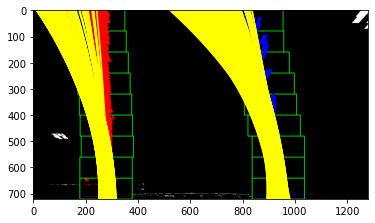

In [15]:
output = 'result.mp4'
clip = VideoFileClip("original.mp4")
video_clip = clip.fl_image(process_image) 
%time video_clip.write_videofile(output, audio=False)